# Customer segmentation

Date from UCI: https://archive.ics.uci.edu/ml/datasets/Online+Retail




In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Fetch the data, this can take up to ~ 2 minutes

In [2]:
%%time
!pip install xlrd # for reading excel
data = pd.read_excel('http://archive.ics.uci.edu/ml/machine-learning-databases/00352/Online%20Retail.xlsx')

    100% |████████████████████████████████| 112kB 2.7MB/s 
CPU times: user 40.2 s, sys: 405 ms, total: 40.6 s
Wall time: 53.1 s


In the data, there are:
- 8 features: InvoiceNo, StockCode, Description, Quanity, InvoiceDate, UnitPrice, CustomerID, Country
- 541909 records
- 25900 Invoice
- 4372 customer with ID. 135080 records have no customerID 
- 4070 StockCode but 4223 Description, so some StockCodes must have more than 1 descriptions
- 38 countries
- Transfactions started from 201-12-01 till 2101-12-09 (based on InvoiceDate)


The data use ~ 33 MB of memory

In [3]:
print('Shape', data.shape)
print('\n\nDate info:', data.info())
print('\n\nnunique', data.nunique())
print('\nTransaction date', data.InvoiceDate.min(), data.InvoiceDate.max())
data.groupby(['StockCode', 'Description']).size().reset_index() # to show that some stockCode are associated with more than 1 description 

data.head()

Shape (541909, 8)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
InvoiceNo      541909 non-null object
StockCode      541909 non-null object
Description    540455 non-null object
Quantity       541909 non-null int64
InvoiceDate    541909 non-null datetime64[ns]
UnitPrice      541909 non-null float64
CustomerID     406829 non-null float64
Country        541909 non-null object
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


Date info: None


nunique InvoiceNo      25900
StockCode       4070
Description     4223
Quantity         722
InvoiceDate    23260
UnitPrice       1630
CustomerID      4372
Country           38
dtype: int64

Transaction date 2010-12-01 08:26:00 2011-12-09 12:50:00


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


### InvoiceNo
- 25900 invoices (9288 are cancellation)
- Most invoices have only 1 type of product
- The median is 10 types of products per invoice
- The mean is 21 types of products
- The maximum number of products is 1114 types of product in a single invoice!!!
- This InvoiceNo is 573585:
    - has 5198 items
    - total spent: \$16875 (wonder if they got discount)
   - on 2010-10-31 14:41
   - in UK
   - unfortunately, no customerID
   - (It must has been quite challenging, thinking about the logistics to get these products together, shipping, etc..)
- Total spent for all the invoices: $9,747,748

count    25900.000000
mean        20.923127
std         43.031334
min          1.000000
25%          2.000000
50%         10.000000
75%         23.000000
max       1114.000000
Name: InvoiceNo, dtype: float64
0 5841 1612 1095 815 788 670 652 631 629 553 573 496 519 521 548 569 454 434 481 438 408 344 356 321
Not cancelled vs cancelled invoice:
 False    532621
True       9288
Name: isCancelled, dtype: int64
Total spent for all invoices: 9747747.933999998
Total spent: 16874.579999999998


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,isCancelled,Monetary
430237,573585,11001,ASSTD DESIGN RACING CAR PEN,2,2011-10-31 14:41:00,3.29,NaN,United Kingdom,False,6.58
430238,573585,15036,ASSORTED COLOURS SILK FAN,15,2011-10-31 14:41:00,1.63,NaN,United Kingdom,False,24.45
430239,573585,15039,SANDALWOOD FAN,15,2011-10-31 14:41:00,1.63,NaN,United Kingdom,False,24.45
430240,573585,15056BL,EDWARDIAN PARASOL BLACK,1,2011-10-31 14:41:00,12.46,NaN,United Kingdom,False,12.46
430241,573585,15056N,EDWARDIAN PARASOL NATURAL,1,2011-10-31 14:41:00,12.46,NaN,United Kingdom,False,12.46


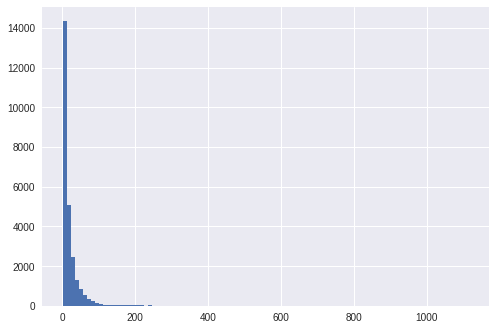

In [4]:
# invoice begin with C is cancelled, create a feature/variable called isCancelled (for the lack of a better term)
data['isCancelled'] = data['InvoiceNo'].astype(str).str.startswith('C')

# create another feature/variable called Monetary
data['Monetary'] = data[['Quantity', 'UnitPrice']].prod(1)

tmp = data['InvoiceNo'].value_counts()
print(tmp.describe())
plt.hist(tmp, 100);
print(*np.bincount(tmp)[:25])

print('Not cancelled vs cancelled invoice:\n', data['isCancelled'].value_counts())

# however, there are 1336 records where the InvoiceNo do not start with C, but the quantity is negative
data.iloc[np.where((~data['isCancelled']) & (data['Quantity'] < 0))]

# good: no records where the InvoiceNo start with C, but the quantity is positive
# data.iloc[np.where((data['isCancelled']) & (data['Quantity'] > 0))]

print('Total spent for all invoices:', data['Monetary'].sum())

# the biggest invoice
tmp = tmp.sort_values(ascending=False).index[0]
print('Total spent:', data[data['InvoiceNo'] == tmp]['Monetary'].sum())
data[data['InvoiceNo'] == tmp].head()

### InvoiceDate
- The dataset cover a period just a little bit over 1 year
- On average, there are ~1449 invoices per day (mean)
- The median is 1427 invoices per day
- They close on Sunday, Xmas, somehere around Easter
- Towards the end of 2011 (from Nov), the number of invoices per day increased steadly, it's Xmas time!

count     374.000000
mean     1448.954545
std      1018.604579
min         0.000000
25%       875.250000
50%      1427.000000
75%      1944.500000
max      5331.000000
dtype: float64


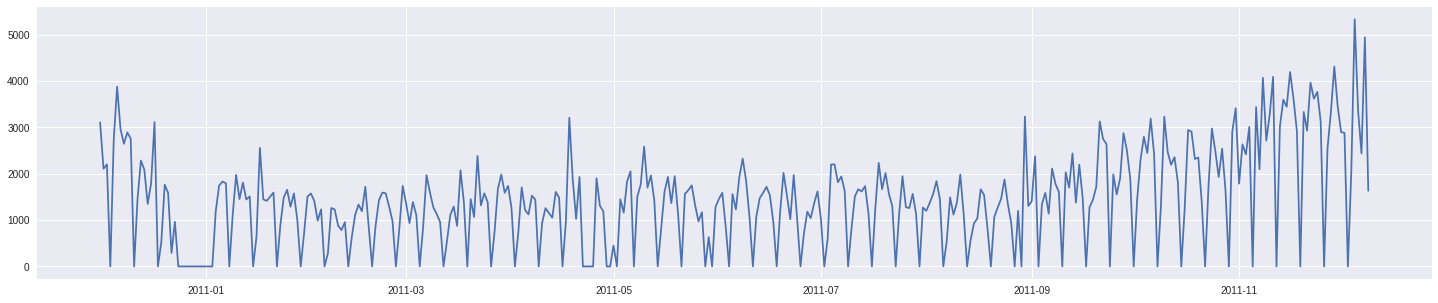

In [5]:
tmp = data.resample('D', on='InvoiceDate').size() # including cancellation
print(tmp.describe())
plt.figure(figsize=(25, 5))
plt.plot(tmp, '-');

### Country
- 38 of them
- But the majority of the transaction and values came from UK

,size,mean,sum
Country,,,
United Kingdom,495478,16.525065,8.187806e+06
Germany,9495,23.348943,2.216982e+05
France,8557,23.069288,1.974039e+05
EIRE,8196,32.122599,2.632768e+05
Spain,2533,21.624390,5.477458e+04


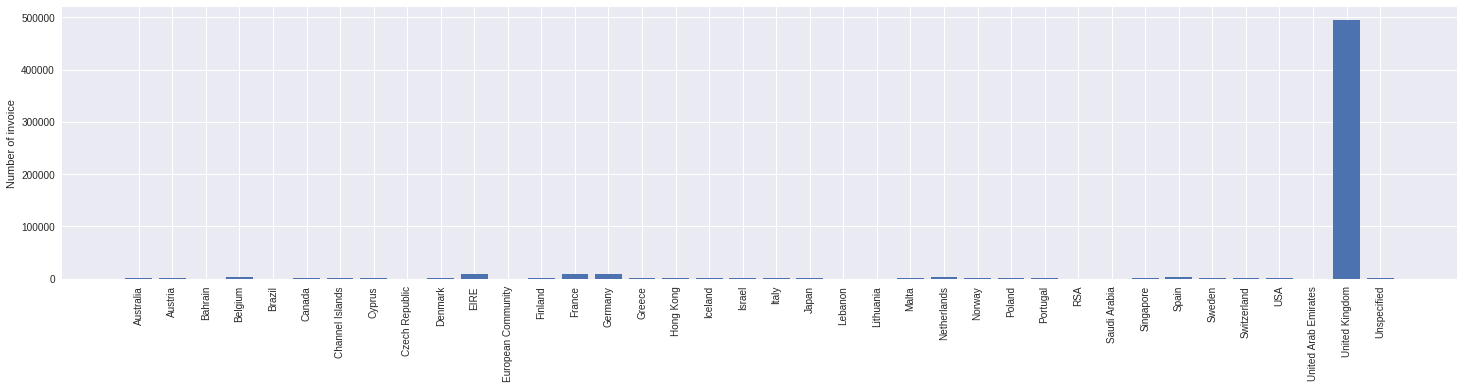

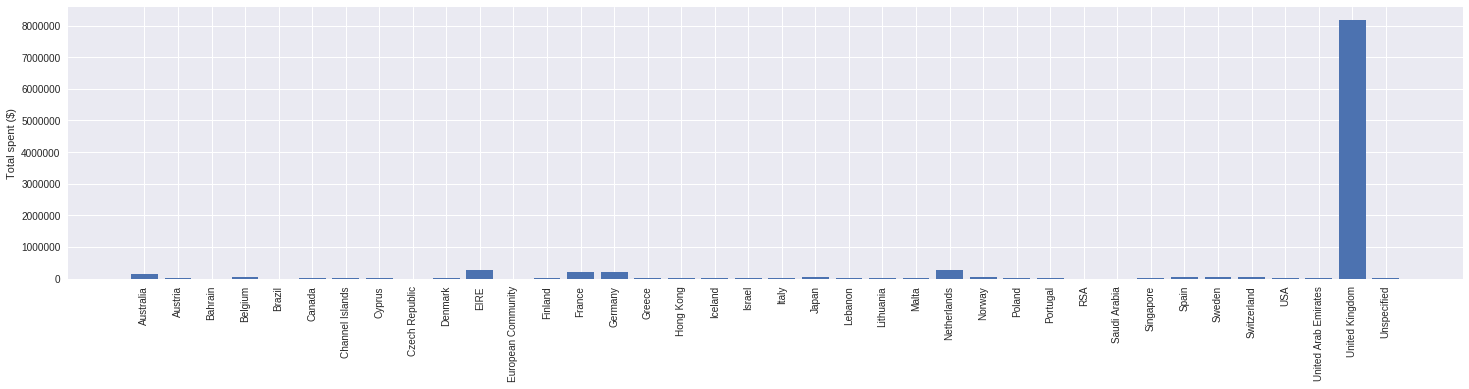

In [6]:
tmp = data.groupby('Country')['Monetary'].agg(['size', 'mean', 'sum']).sort_values('size', ascending=False)
plt.figure(figsize=(25, 5))
plt.bar(tmp.index, tmp['size'])
plt.ylabel('Number of invoice')
plt.xticks(tmp.index, tmp.index, rotation='vertical')

plt.figure(figsize=(25, 5))
plt.bar(tmp.index, tmp['sum'])
plt.ylabel('Total spent ($)')
plt.xticks(tmp.index, tmp.index, rotation='vertical');

tmp.head()

We are going to reduce the size of the dataset
- Remove records with no customerID
- Only retain records in UK (because some researches indicate that customer clusters vary by geography)
- Keep only records after 2010-12-09, because the last invoice was dated 2011-12-09 (1 year of records)
- Remove invoices which were cancellation

Now, there are:
- 3862 unique customer
- 16014 unique invoices

Add additional metrics:
- Recency: number of days elapsed since the customer last purchased anything. Smaller numbers indicate more recent activities. Since the last InvoiceDate is 2011-12-09, we will use 2011-12-10 as our reference day.
- Frequency: number of invoices with purchases during the examined periods (2010-12-09 to 2011-12-09)

Since the original dataset is in a long format, we are going to transform it into wide format with CustomerID as row. The finaly dataset:
- 3862 rows
- 3 features: Recency, Frequency and Monetary value. These are collectively known as the RFM value

In [7]:
# create a new dataset
data2 = data[
    (data['CustomerID'].notnull()) & # CustomerID is present 
    (data['Country'] == 'United Kingdom') & # in UK
    (data['InvoiceDate'] > pd.to_datetime('20101209')) & # After 2010-12-09
    (data['Monetary'] > 0) # have actually spent money, not just bought stuff and then returned them all
].drop(columns=['Country'])

print('Unique CustomerID:', data2.CustomerID.nunique(), 'Unique InvoiceNo', data2.InvoiceNo.nunique())



# Recency: number of days elapsed since the customer last purchased something 
data2['Recency'] = data2['InvoiceDate'].dt.date.max() + pd.to_timedelta('1 day') - data2['InvoiceDate'].dt.date # The maximum of InvoiceDate (2011-12-09) plus an extra day minus InvoiceDate
data2['Recency'] = data2['Recency'].dt.days # convert to days in integer

# now transform into a dataframe with CustomerID as row
data2 = data2.groupby('CustomerID').agg({
    'Recency': 'min',
    'InvoiceNo': lambda x: x.nunique(),
    'Monetary': lambda x: x.sum(),
}).rename(columns={ 'InvoiceNo': 'Frequency' })


print('New shape', data2.shape)
data2.head(10)

Unique CustomerID: 3862 Unique InvoiceNo 16014
New shape (3862, 3)


,Recency,Frequency,Monetary
CustomerID,,,
12346.0,326,1,77183.60
12747.0,3,10,3837.45
12748.0,1,195,31854.58
12749.0,4,5,4090.88
12820.0,4,4,942.34
12821.0,215,1,92.72
12822.0,71,2,948.88
12823.0,75,5,1759.50
12824.0,60,1,397.12


### The 80/20 rule

The 80/20 rule (also known as the [Pareto Principle](https://en.wikipedia.org/wiki/Pareto_principle), the law of the vital few, or the principle of factor sparsity) states that for many events, ~80% of the results come from 20% of the causes. In this case, about 80% of the sales would be produced by the top ~20% of the customers. These 20% are the high-value, important customers a business would like to keep.

In our dataset:
- Total monetary value: \$7,058,375, 80% is: \$5,646,700
- Total customers: 3863, top 20% is: 772
- Calculated numbers of customers spending a combined 80% is: 1069
- This is ~28% rather than 20%, but it's close enough.

Total monetary value: 7058375.114
80% monetary value: 5646700.091200001
1069


,Recency,Frequency,Monetary,Top20
CustomerID,,,,
18102.0,1,57,233736.93,1
17450.0,9,44,192521.95,1
16446.0,1,2,168472.50,1
17511.0,3,29,87591.70,1
12346.0,326,1,77183.60,1
16029.0,39,60,76753.32,1
16684.0,5,28,66653.56,1
14096.0,5,17,65164.79,1
13694.0,4,49,64197.50,1


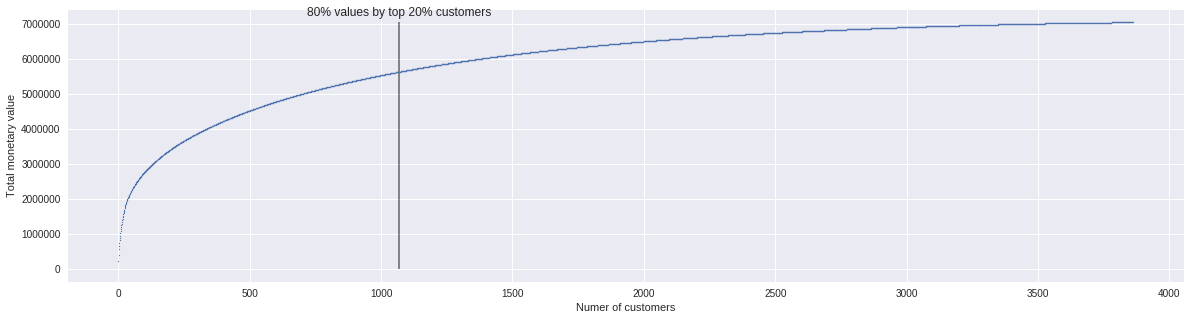

In [8]:
print('Total monetary value:', data2['Monetary'].sum())
print('80% monetary value:', data2['Monetary'].sum() * 0.8)

data2 = data2.sort_values('Monetary', ascending=False) # sort by monetary value from high to low

# combined customers spent ~ 80% of the total
data2['Top20'] = np.where(data2['Monetary'].cumsum() < data2['Monetary'].sum() * 0.8, 1, 0)
print(data2['Top20'].sum())

plt.figure(figsize=(20, 5))
plt.plot(range(len(data2)), data2['Monetary'].cumsum(), '.', markersize=2.5)
plt.vlines(data2['Top20'].sum(), 0, data2['Monetary'].sum(), alpha=0.5)
plt.xlabel('Numer of customers')
plt.ylabel('Total monetary value')
plt.annotate('80% values by top 20% customers', (data2['Top20'].sum(), data2['Monetary'].sum() * 1.025), ha='center')

data2[data2['Top20'] == 1].head(10)

### Data transformation

At the moment, the scales of each feature are quite huge and not normally distributed. It's a good idea to log transform and normalise them.



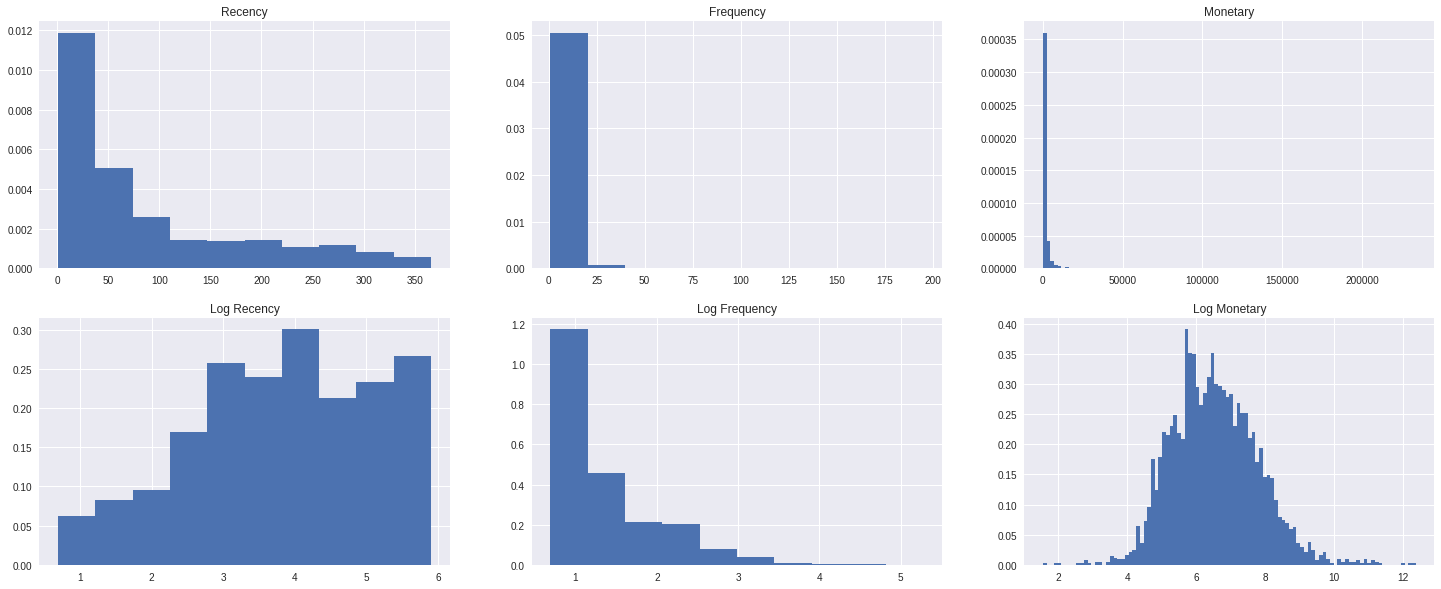

In [9]:
_, axs = plt.subplots(2, 3, figsize=(25, 10))
axs[0, 0].hist(data2['Recency'], normed=True)
axs[0, 0].set_title('Recency')
axs[0, 1].hist(data2['Frequency'], normed=True)
axs[0, 1].set_title('Frequency')
axs[0, 2].hist(data2['Monetary'], 100, normed=True)
axs[0, 2].set_title('Monetary')

# create a new dataframe which is log1p of data2
data3 = np.log1p(data2.drop('Top20', 1))
data3['Top20'] = data2['Top20']

axs[1, 0].hist(data3['Recency'], normed=True)
axs[1, 0].set_title('Log Recency')
axs[1, 1].hist(data3['Frequency'], normed=True)
axs[1, 1].set_title('Log Frequency')
axs[1, 2].hist(data3['Monetary'], 100, normed=True)
axs[1, 2].set_title('Log Monetary');

### Relationship between features/variables
- The more recent, the higher the monetary values
- The more frequent, also the higher the monetary values



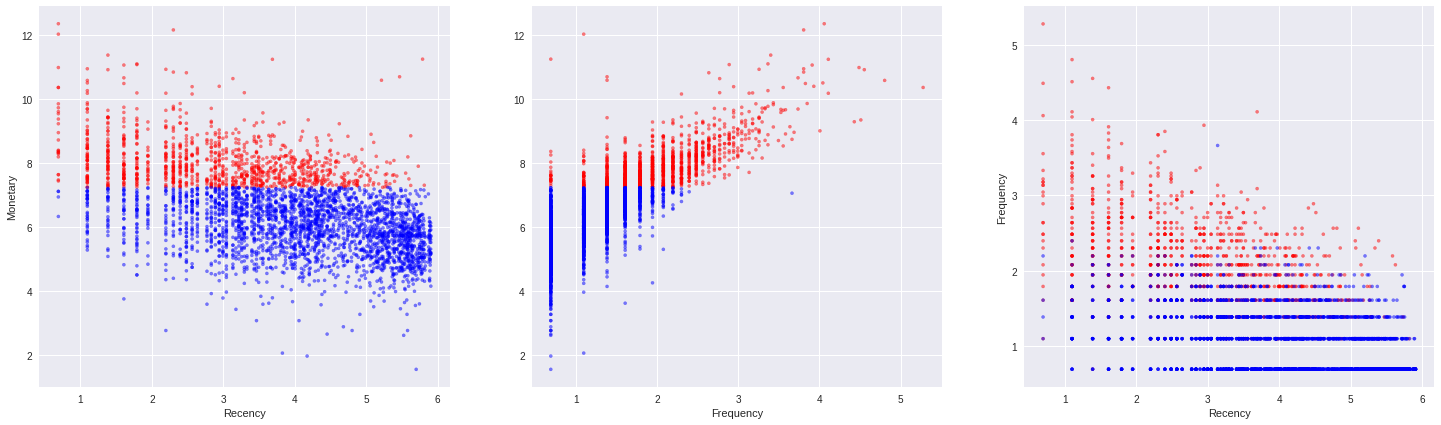

In [10]:
# a function to plot clusters based on colors
def plot(colors):
    _, axs = plt.subplots(1, 3, figsize=(25, 7))
    axs[0].scatter(data3['Recency'], data3['Monetary'], s=10, alpha=0.5, c=colors)
    axs[0].set_xlabel('Recency')
    axs[0].set_ylabel('Monetary')
    axs[1].scatter(data3['Frequency'], data3['Monetary'], s=10, alpha=0.5, c=colors)
    axs[1].set_xlabel('Frequency')
    axs[2].scatter(data3['Recency'], data3['Frequency'], s=10, alpha=0.5, c=colors)
    axs[2].set_xlabel('Recency')
    axs[2].set_ylabel('Frequency')
    
plot(np.where(data3['Top20'] == 1, 'red', 'blue'))

### Clustering

### K-means

Starting with 2 clusters, we can see that the algorithm is just splitting the data into 2 equal groups
- 0: Low monetary, low frequency, and high recency
- 1: High monetary, high frequency and low recency

,Recency,Frequency,Monetary,Top20
0,16,5,1816.745,1
1,104,1,337.390,0


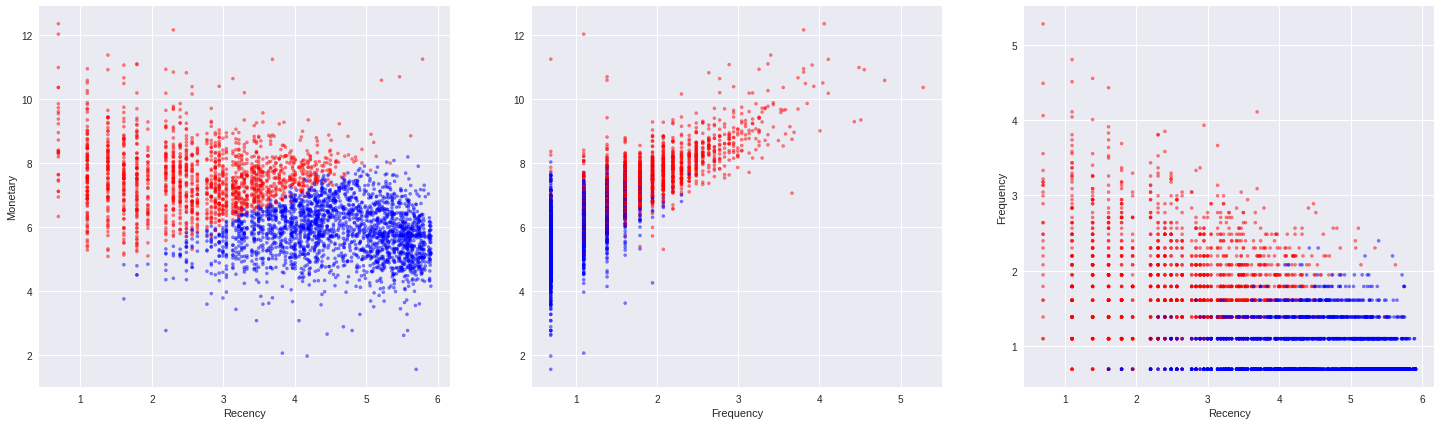

In [11]:
from sklearn.cluster import KMeans

# features to use
cols = ['Recency', 'Frequency', 'Monetary']

# colors
c = { 0: 'red', 1: 'blue', 2: 'green', 3: 'yellow', 4: 'orange', 5: 'pink', 6: 'purple', 7: 'silver', 8: 'maroon', 9: 'lime' }

# kmeans classifier
clfs = []

for i in range(2, 11):
    clf = KMeans(n_clusters=i, random_state=0)
    clf.fit(data3[cols])
    clfs.append(clf)

# with 2 clusters
plot([c[i] for i in clfs[0].labels_])
data2.groupby(clfs[0].labels_).median()

,Recency,Frequency,Monetary,Top20
0,34,3,770.60,0
1,9,8,2974.65,1
2,178,1,270.80,0


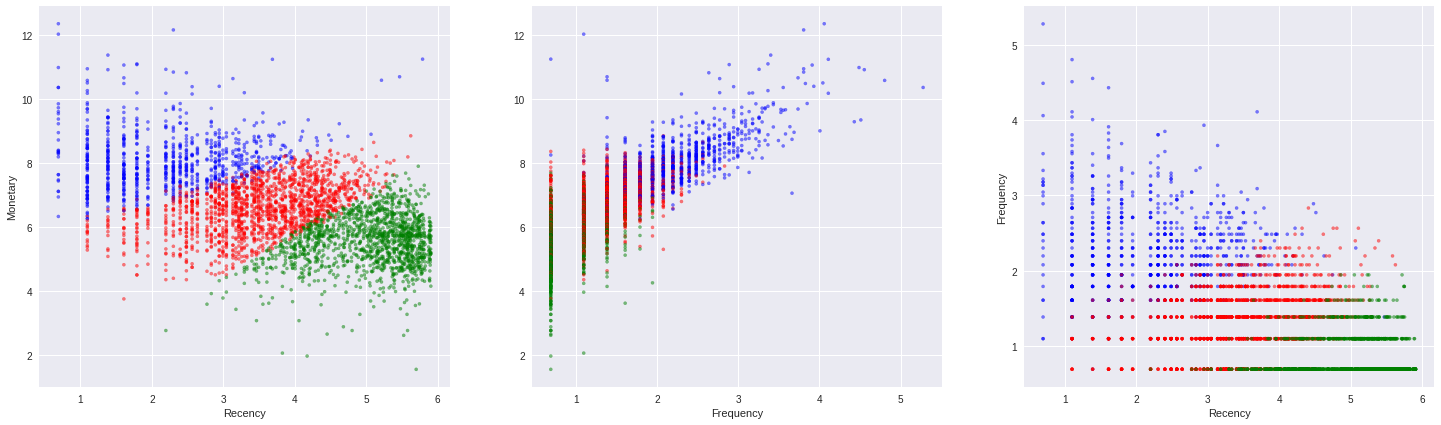

In [12]:
# with 3 clusters
plot([c[i] for i in clfs[1].labels_])
data2.groupby(clfs[1].labels_).median()

,Recency,Frequency,Monetary,Top20
0,39,1,289.99,0
1,8,12,4482.77,1
2,219,1,267.03,0
3,11,4,1041.61,0
4,65,3,1240.26,0


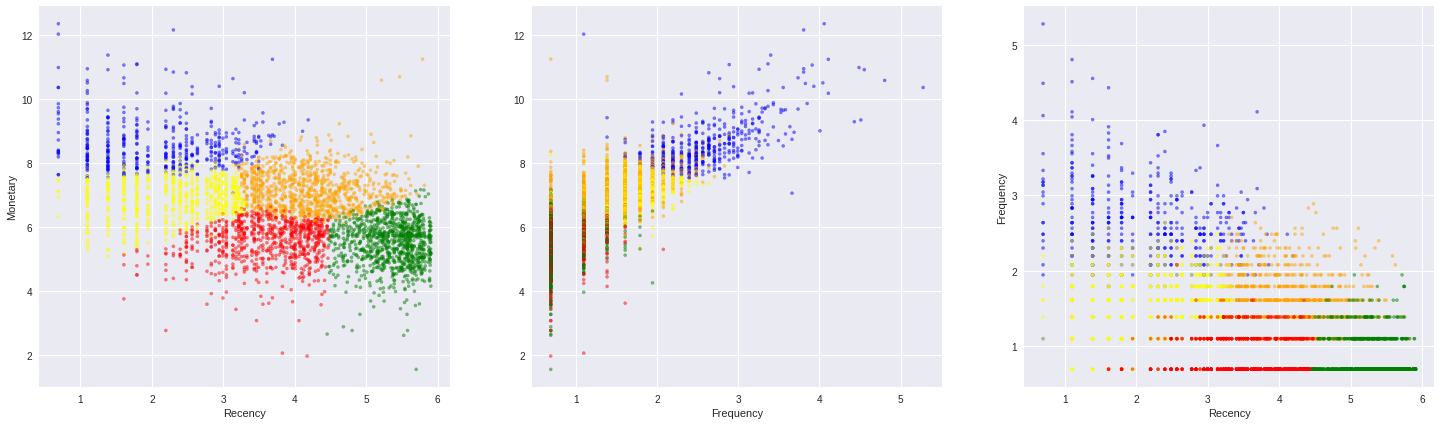

In [13]:
# with 5 clusters
plot([c[i] for i in clfs[3].labels_])
data2.groupby(clfs[3].labels_).median()

,Recency,Frequency,Monetary,Top20
0,41.0,1.0,164.285,0.0
1,82.0,4.0,1569.925,1.0
2,22.5,4.0,1094.265,0.0
3,58.0,2.0,483.400,0.0
4,5.0,6.0,2050.080,1.0
5,212.0,1.0,418.920,0.0
6,4.0,21.0,10399.740,1.0
7,23.0,9.0,3650.410,1.0
8,234.0,1.0,151.420,0.0
9,9.0,2.0,370.840,0.0


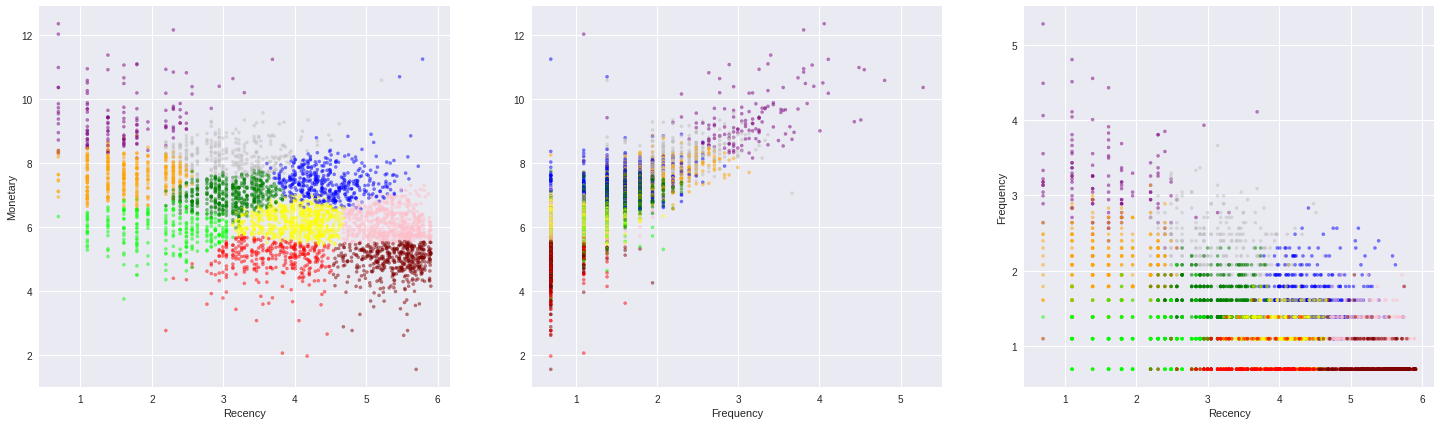

In [14]:
# with 10 clusters
plot([c[i] for i in clfs[8].labels_])
data2.groupby(clfs[8].labels_).median()

So how many clusters should there be? There are several metrics we can use:
- Inertia, or within-cluster sum-of-squares, smaller better
- silhouette score, range -1 to 1, best value is 1, worst is -1, 
- Calinski-Harabaz index, higer is better
- Davies-Bouldin index, lower is better

References: http://scikit-learn.org/stable/modules/clustering.html

From the graphs below, it looks like 2 clusters are optimal.

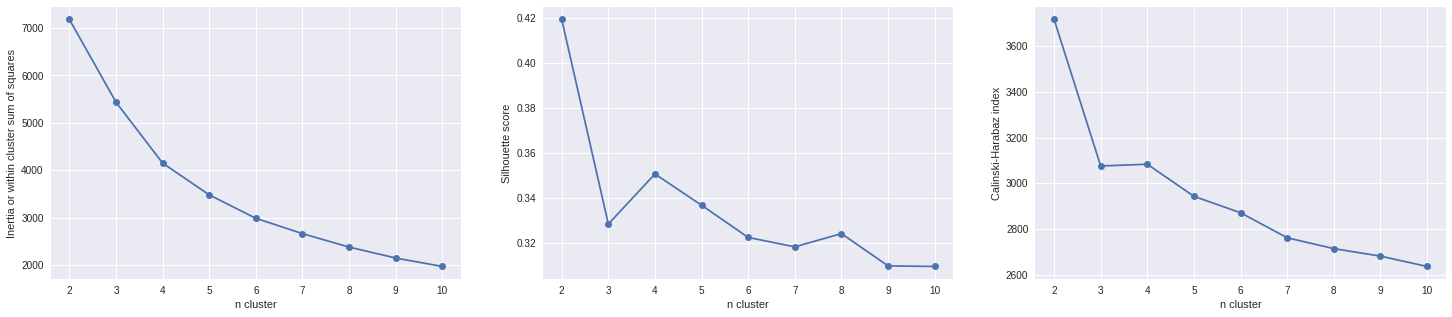

In [15]:
from sklearn import metrics

_, axs = plt.subplots(1, 3, figsize=(25, 5))
# using inertia or within-cluster sum-of-squares
axs[0].plot([clf.n_clusters for clf in clfs], [clf.inertia_ for clf in clfs], '-o')
axs[0].set_ylabel('Inertia or within cluster sum of squares')
axs[0].set_xlabel('n cluster')

# silhouette score
axs[1].plot([clf.n_clusters for clf in clfs], [metrics.silhouette_score(data3[cols], clf.labels_) for clf in clfs], '-o')
axs[1].set_ylabel('Silhouette score')
axs[1].set_xlabel('n cluster')

# calinski_harabaz_score
axs[2].plot([clf.n_clusters for clf in clfs], [metrics.calinski_harabaz_score(data3[cols], clf.labels_) for clf in clfs], '-o')
axs[2].set_ylabel('Calinski-Harabaz index')
axs[2].set_xlabel('n cluster');

# Davies-Bouldin, gave error: module 'sklearn.metrics' has no attribute 'davies_bouldin_score'
# axs[3].plot([clf.n_clusters for clf in clfs], [metrics.davies_bouldin_score(data3[cols], clf.labels_) for clf in clfs], '-o')
# axs[3].set_ylabel('Davies Bouldin index')
# axs[3].set_xlabel('n cluster');

While we are here, we may just as well explore other clustering algorithms.

They make pretty graphs!

In [128]:
%%time

# try other clustering algorithms

from sklearn import cluster, mixture

# clustering algorithms to try
algos = {}
algos['KMeans'] = cluster.KMeans(n_clusters=2).fit(data3[cols])
algos['MeanShift'] = cluster.MeanShift().fit(data3[cols])
algos['AgglomerativeClustering_ward'] = cluster.AgglomerativeClustering(n_clusters=2, linkage='ward').fit(data3[cols])
algos['AgglomerativeClustering_complete'] = cluster.AgglomerativeClustering(n_clusters=2, linkage='complete').fit(data3[cols])
algos['AgglomerativeClustering_average'] = cluster.AgglomerativeClustering(n_clusters=2, linkage='average').fit(data3[cols])
# algos['AgglomerativeClustering_single'] = cluster.AgglomerativeClustering(n_clusters=2, linkage='single').fit(data3[cols])
algos['SpectralClustering'] = cluster.SpectralClustering(n_clusters=2).fit(data3[cols])
algos['Birch'] = cluster.Birch(n_clusters=2).fit(data3[cols])
algos['GaussianMixture_full'] = mixture.GaussianMixture(n_components=2, covariance_type='full').fit(data3[cols])
algos['GaussianMixture_full'].labels_ = algos['GaussianMixture_full'].predict(data3[cols])
algos['GaussianMixture_tied'] = mixture.GaussianMixture(n_components=2, covariance_type='tied').fit(data3[cols])
algos['GaussianMixture_tied'].labels_ = algos['GaussianMixture_tied'].predict(data3[cols])
algos['GaussianMixture_diag'] = mixture.GaussianMixture(n_components=2, covariance_type='diag').fit(data3[cols])
algos['GaussianMixture_diag'].labels_ = algos['GaussianMixture_diag'].predict(data3[cols])
algos['GaussianMixture_spherical'] = mixture.GaussianMixture(n_components=2, covariance_type='spherical').fit(data3[cols])
algos['GaussianMixture_spherical'].labels_ = algos['GaussianMixture_spherical'].predict(data3[cols])
algos['DBSCAN'] = cluster.DBSCAN(eps=0.5).fit(data3[cols])
algos['DBSCAN'].labels_ = np.where(algos['DBSCAN'].labels_ == -1, 1, algos['DBSCAN'].labels_)
# algos['AffinityPropagation'] = cluster.AffinityPropagation(damping=) # take a long time to run

/usr/local/lib/python3.6/dist-packages/scipy/sparse/csgraph/_laplacian.py:72: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if normed and (np.issubdtype(csgraph.dtype, int)


CPU times: user 36.3 s, sys: 1.23 s, total: 37.5 s
Wall time: 34.7 s


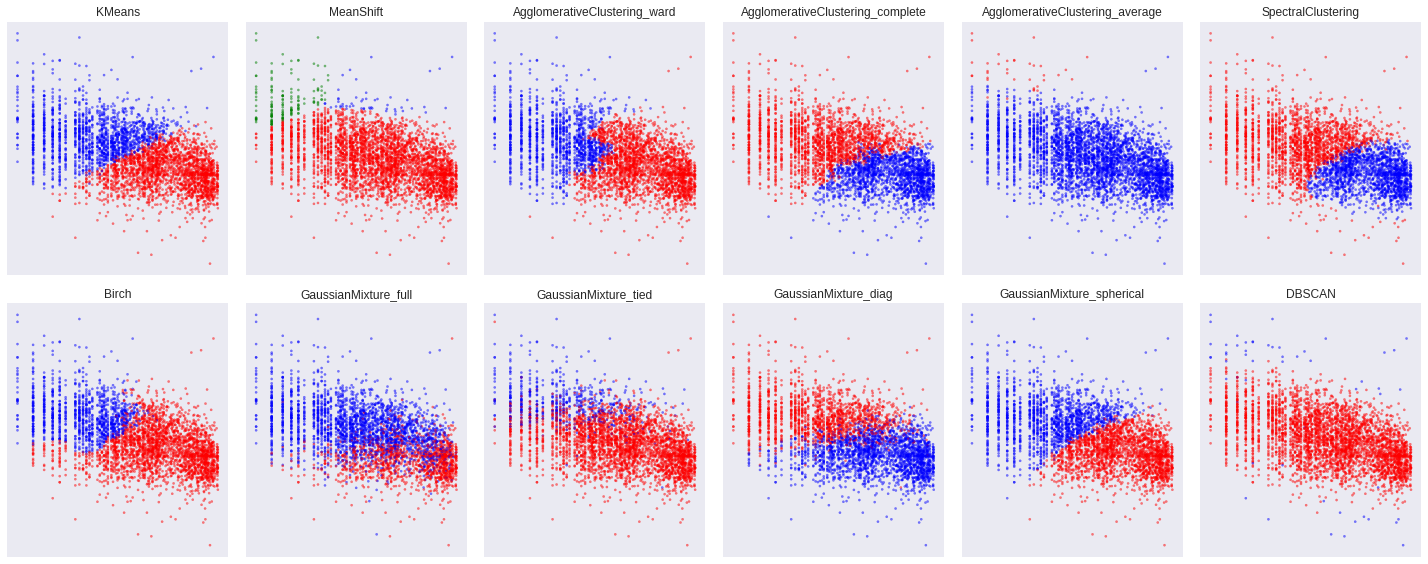

In [147]:
plot_number = 1

plt.figure(figsize=(20, 8))
plt.subplots_adjust(wspace=.05, hspace=.05)

for name, clf in algos.items():
    plt.subplot(2, 6, plot_number)
    plt.scatter(data3['Recency'], data3['Monetary'], alpha=0.5, s=5, c=[c[i] for i in clf.labels_])
    plt.title(name)
    plt.xticks(())
    plt.yticks(())
    plot_number += 1

plt.tight_layout()

Text(0.5,1,'Calinski Harabaz index')

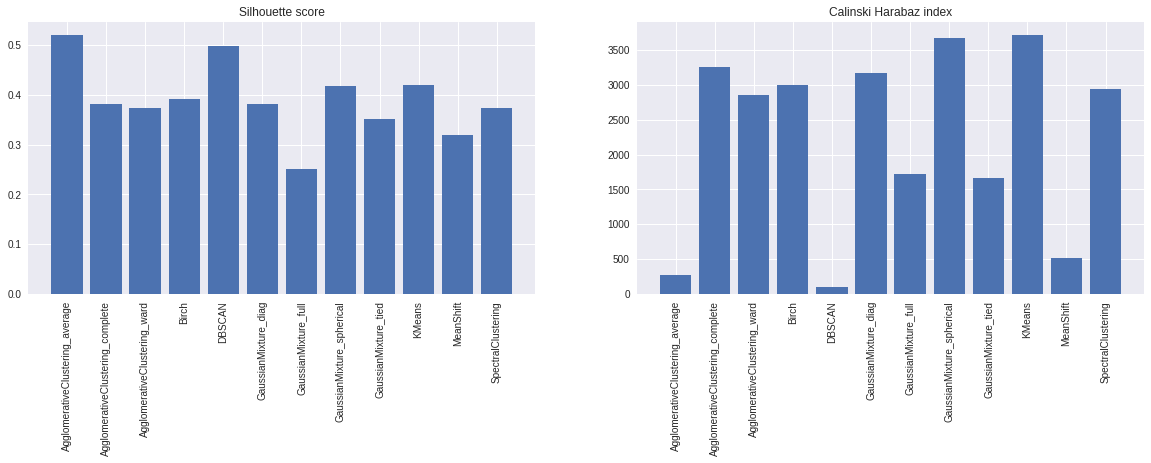

In [154]:
plt.figure(figsize=(20, 5))

plt.subplot(1, 2, 1)
plt.bar(algos.keys(), [metrics.silhouette_score(data3[cols], clf.labels_) for clf in algos.values()])
plt.xticks(rotation='vertical')
plt.title('Silhouette score')

plt.subplot(1, 2, 2)
plt.bar(algos.keys(), [metrics.calinski_harabaz_score(data3[cols], clf.labels_) for clf in algos.values()])
plt.xticks(rotation='vertical')
plt.title('Calinski Harabaz index');